# Long-Short Strategy, Part 4: How to interpret GBM results

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. `model_interpretation` (this noteboook): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Understanding why a model predicts a certain outcome is very important for several reasons, including trust, actionability, accountability, and debugging. 

Insights into the nonlinear relationship between features and the outcome uncovered by the model, as well as interactions among features, are also of value when the goal is to learn more about the underlying drivers of the phenomenon under study.

## Imports & Settings

In [1]:
%matplotlib inline

import warnings
from itertools import product
from pathlib import Path
from random import randint

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

/Users/gerardcasanovasjimenez/Projects/tfm/sp500_investing_feature_engineering/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
idx = pd.IndexSlice
np.random.seed(42)

In [3]:
DATA_STORE = Path("../data/assets.h5")

## Retrieve best model parameters

In [4]:
tiporf = 0  # 0 para LGBM

The results used below are created by the notebooks [gbm_trading_signals](05_gbm_trading_signals.ipynb).

In [5]:
with pd.HDFStore("data.h5") as store:
    best_params = store["best_params_rf"]
    if tiporf == 0:
        best_params = store["best_params"]

In [6]:
best_params

train_length        216.00
test_length          12.00
learning_rate         0.30
num_leaves            4.00
feature_fraction      0.95
min_data_in_leaf    100.00
boost_rounds         50.00
Name: 410, dtype: float64

## Get Training Data

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    keys = store.keys()
for key in keys:
    print(key)

/data_close
/data_raw
/engineered_features


In [8]:
data = pd.read_hdf(DATA_STORE, "engineered_features").sort_index()
data0 = data.copy()
data = data.loc[idx[:, "2019":"2024"], :]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2817 entries, ('XLB', Timestamp('2019-01-06 00:00:00')) to ('XLY', Timestamp('2024-12-29 00:00:00'))
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_1w                  2817 non-null   float64
 1   return_2w                  2817 non-null   float64
 2   return_3w                  2817 non-null   float64
 3   return_6w                  2817 non-null   float64
 4   return_12w                 2817 non-null   float64
 5   return_52w                 2817 non-null   float64
 6   const                      2817 non-null   float64
 7   Mkt-RF                     2817 non-null   float64
 8   SMB                        2817 non-null   float64
 9   HML                        2817 non-null   float64
 10  RMW                        2817 non-null   float64
 11  CMA                        2817 non-null   float64
 12  const_diff                 

In [10]:
# miramos las exposiciones a los factores
resultado = data.groupby(level=0).last().iloc[:, 6:11]
print(resultado)

           const    Mkt-RF       SMB       HML       RMW
ticker                                                  
XLB    -0.001046  1.106067  0.095914  0.202237  0.233875
XLE     0.005316  0.937485 -0.267260  0.779214  0.254106
XLF     0.005079  0.908720 -0.066362  0.797782 -0.093850
XLI     0.007613  1.014962  0.273221  0.011693  0.271958
XLK     0.004028  1.272026 -0.261863 -0.351528 -0.004465
XLP     0.001676  0.618957  0.044330 -0.311150  0.335214
XLU    -0.001974  0.651215 -0.069941 -0.203308  0.281056
XLV     0.001576  0.580042 -0.072447  0.010405  0.265294
XLY    -0.005312  1.191913  0.203951 -0.032134 -0.277251


In [11]:
unknown_tickers = data[data["sector"] == "Unknown"].index.get_level_values(0)

In [12]:
unknown_tickers.unique()

Index([], dtype='object', name='ticker')

In [13]:
data["sector"].unique()

array(['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'],
      dtype=object)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2817 entries, ('XLB', Timestamp('2019-01-06 00:00:00')) to ('XLY', Timestamp('2024-12-29 00:00:00'))
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_1w                  2817 non-null   float64
 1   return_2w                  2817 non-null   float64
 2   return_3w                  2817 non-null   float64
 3   return_6w                  2817 non-null   float64
 4   return_12w                 2817 non-null   float64
 5   return_52w                 2817 non-null   float64
 6   const                      2817 non-null   float64
 7   Mkt-RF                     2817 non-null   float64
 8   SMB                        2817 non-null   float64
 9   HML                        2817 non-null   float64
 10  RMW                        2817 non-null   float64
 11  CMA                        2817 non-null   float64
 12  const_diff                 

## Tratamiento NaN

In [15]:
# completamos con los valores del periodo anterior, para evitar que el último dato apareza nan
data = data.fillna(method="ffill")

## Create Binary Data

In [16]:
dates = sorted(data.index.get_level_values("date").unique())

In [17]:
train_dates = dates[
    -int(best_params.train_length + best_params.test_length) : -int(
        best_params.test_length
    )
]

In [18]:
train_dates

[Timestamp('2020-08-23 00:00:00'),
 Timestamp('2020-08-30 00:00:00'),
 Timestamp('2020-09-06 00:00:00'),
 Timestamp('2020-09-13 00:00:00'),
 Timestamp('2020-09-20 00:00:00'),
 Timestamp('2020-09-27 00:00:00'),
 Timestamp('2020-10-04 00:00:00'),
 Timestamp('2020-10-11 00:00:00'),
 Timestamp('2020-10-18 00:00:00'),
 Timestamp('2020-10-25 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-11-08 00:00:00'),
 Timestamp('2020-11-15 00:00:00'),
 Timestamp('2020-11-22 00:00:00'),
 Timestamp('2020-11-29 00:00:00'),
 Timestamp('2020-12-06 00:00:00'),
 Timestamp('2020-12-13 00:00:00'),
 Timestamp('2020-12-20 00:00:00'),
 Timestamp('2020-12-27 00:00:00'),
 Timestamp('2021-01-03 00:00:00'),
 Timestamp('2021-01-10 00:00:00'),
 Timestamp('2021-01-17 00:00:00'),
 Timestamp('2021-01-24 00:00:00'),
 Timestamp('2021-01-31 00:00:00'),
 Timestamp('2021-02-07 00:00:00'),
 Timestamp('2021-02-14 00:00:00'),
 Timestamp('2021-02-21 00:00:00'),
 Timestamp('2021-02-28 00:00:00'),
 Timestamp('2021-03-

In [19]:
len(train_dates)

216

In [20]:
data_copia = data.copy()

In [21]:
data = data.loc[idx[:, train_dates], :]

In [22]:
labels = sorted(data.filter(like="target").columns)  # modificado
features = data.columns.difference(labels).tolist()

In [23]:
features

['1y_yield',
 '1y_yield_chg',
 '1y_yield_diff',
 'CMA',
 'CMA_diff',
 'HML',
 'HML_diff',
 'Mkt-RF',
 'Mkt-RF_diff',
 'RMW',
 'RMW_diff',
 'SMB',
 'SMB_diff',
 'const',
 'const_diff',
 'corp_oas',
 'corp_oas_chg',
 'corp_oas_diff',
 'empleo_chg',
 'empleo_diff',
 'eu_hy_oas',
 'eu_hy_oas_chg',
 'eu_hy_oas_diff',
 'hy_oas',
 'hy_oas_chg',
 'hy_oas_diff',
 'inflacion',
 'inflacion_chg',
 'inflacion_diff',
 'leading',
 'leading_chg',
 'leading_diff',
 'momentum_12',
 'momentum_2',
 'momentum_3',
 'momentum_3_12',
 'momentum_52',
 'momentum_6',
 'month',
 'oil',
 'oil_chg',
 'oil_diff',
 'real_gdp',
 'real_gdp_chg',
 'real_gdp_diff',
 'recession',
 'recession_chg',
 'recession_diff',
 'retail_sales',
 'retail_sales_chg',
 'retail_sales_diff',
 'retail_sales_percent',
 'retail_sales_percent_chg',
 'retail_sales_percent_diff',
 'return_12w',
 'return_1w',
 'return_1w_t-1',
 'return_1w_t-2',
 'return_1w_t-3',
 'return_1w_t-4',
 'return_1w_t-5',
 'return_1w_t-6',
 'return_2w',
 'return_3w',
 '

In [24]:
lookahead = 1
label = "target_1w"

In [25]:
categoricals = ["month", "sector"]

In [26]:
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [27]:
lgb_train = lgb.Dataset(
    data=data[features],
    label=data[label],
    categorical_feature=categoricals,
    free_raw_data=False,
)

## Train LightGBM Model

In [28]:
params = dict(boosting="rf", objective="regression", bagging_freq=1, verbose=-1)
if tiporf == 0:
    params = dict(boosting="gbdt", objective="regression", verbose=-1)

In [29]:
train_params = ["bagging_fraction", "feature_fraction", "min_data_in_leaf", "max_depth"]
if tiporf == 0:
    train_params = [
        "learning_rate",
        "num_leaves",
        "feature_fraction",
        "min_data_in_leaf",
    ]

In [30]:
if tiporf == 1:
    params.update(best_params.loc[train_params].to_dict())
    for p in ["min_data_in_leaf", "max_depth"]:
        params[p] = int(params[p])

if tiporf == 0:
    params.update(best_params.loc[train_params].to_dict())
    for p in ["min_data_in_leaf", "num_leaves"]:
        params[p] = int(params[p])

In [31]:
best_params

train_length        216.00
test_length          12.00
learning_rate         0.30
num_leaves            4.00
feature_fraction      0.95
min_data_in_leaf    100.00
boost_rounds         50.00
Name: 410, dtype: float64

In [32]:
params

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'learning_rate': 0.3,
 'num_leaves': 4,
 'feature_fraction': 0.95,
 'min_data_in_leaf': 100}

In [33]:
# cambiamos params.bagging_fraction por que si no da error. Es algo a revisar a futuro ya que estamos cambiando una configuración.
# params['bagging_fraction']=1

In [34]:
params

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'learning_rate': 0.3,
 'num_leaves': 4,
 'feature_fraction': 0.95,
 'min_data_in_leaf': 100}

In [35]:
lgb_model = lgb.train(
    params=params, train_set=lgb_train, num_boost_round=int(best_params.boost_rounds)
)

In [36]:
data_copia.loc["XLK"].tail(1)

return_1w  return_2w  return_3w  return_6w  return_12w  \
date                                                                 
2024-12-29   0.252701  -0.116546  -0.264357   0.734672    0.830545   

            return_52w     const    Mkt-RF       SMB       HML  ...  \
date                                                            ...   
2024-12-29     3.14994  0.004028  1.272026 -0.261863 -0.351528  ...   

            weekjobclaims_diff  weekjobclaims_chg  retail_sales_percent_diff  \
date                                                                           
2024-12-29            -10000.0          -0.045662                        0.2   

            retail_sales_percent_chg  retail_sales_diff  retail_sales_chg  \
date                                                                        
2024-12-29                  0.285714             5563.0          0.009019   

            us_asset_balance_diff  us_asset_balance_chg  1y_yield_diff  \
date                                                                     
2024-12-29                  169.0              0.000039          -0.07   

            1y_yield_chg  
date                      
2024-12-29     -0.016393  

[1 rows x 89 columns]

In [37]:
for feature in categoricals:
    data_copia[feature] = pd.factorize(data_copia[feature], sort=True)[0]

In [38]:
lgb_model.predict(data_copia.loc["XLK", features].tail(1))

array([-0.14745539])

## Compute Feature Importance

A common approach to gaining insights into the predictions made by tree ensemble methods, such as gradient boosting or random forest models, is to attribute feature importance values to each input variable. These feature importance values can be computed on an individual basis for a single prediction or globally for an entire dataset (that is, for all samples) to gain a higher-level perspective on how the model makes predictions.

There are three primary ways to compute global feature importance values:
- Gain: This classic approach introduced by Leo Breiman in 1984 uses the total reduction of loss or impurity contributed by all splits for a given feature. The motivation is largely heuristic, but it is a commonly used method to select features.
- Split count: This is an alternative approach that counts how often a feature is used to make a split decision, based on the selection of features for this purpose based on the resultant information gain.
- Permutation: This approach randomly permutes the feature values in a test set and measures how much the model's error changes, assuming that an important feature should create a large increase in the prediction error. Different permutation choices lead to alternative implementations of this basic approach.

All gradient boosting implementations provide feature-importance scores after training as a model attribute. The `lightGBM` library provides five versions, as shown in the following list:
- total_gain and gain as its average per split
- total_cover as the number of samples per split when a feature was used
- weight as the split count from preceding values

These values are available using the trained model's .feature_importance() method with the corresponding importance_type parameter. For the best performing XGBoost model, the results are as follows (the total measures have a correlation of 0.8, as do cover and total_cover):

While the indicators for different months and years dominate, the most recent 1m return is the second-most important feature from a total_gain perspective, and is used frequently according to the weight measure, but produces low average gains as it is applied to relatively few instances on average).

In [39]:
def get_feature_importance(model, importance_type="split"):
    fi = pd.Series(
        model.feature_importance(importance_type=importance_type),
        index=model.feature_name(),
    )
    return fi / fi.sum()

In [40]:
feature_importance = (
    get_feature_importance(lgb_model)
    .to_frame("Split")
    .join(get_feature_importance(lgb_model, "gain").to_frame("Gain"))
)

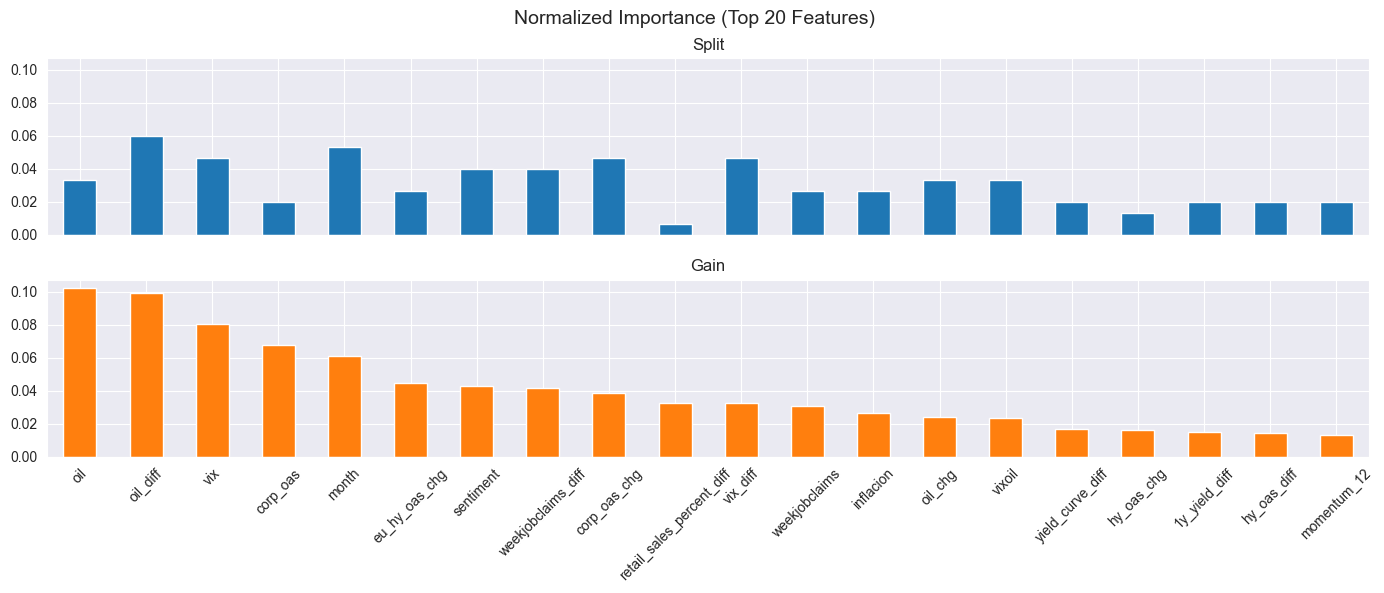

In [41]:
(
    feature_importance.nlargest(20, columns="Gain")
    .sort_values("Gain", ascending=False)
    .plot.bar(
        subplots=True, layout=(2, 1), figsize=(14, 6), legend=False, sharey=True, rot=45
    )
)
plt.suptitle("Normalized Importance (Top 20 Features)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9);

In [42]:
(feature_importance.nlargest(20, columns="Gain").sort_values("Gain", ascending=False))

Split      Gain
oil                        0.033333  0.102027
oil_diff                   0.060000  0.099237
vix                        0.046667  0.080209
corp_oas                   0.020000  0.067560
month                      0.053333  0.060992
eu_hy_oas_chg              0.026667  0.044737
sentiment                  0.040000  0.042786
weekjobclaims_diff         0.040000  0.041565
corp_oas_chg               0.046667  0.038515
retail_sales_percent_diff  0.006667  0.032696
vix_diff                   0.046667  0.032618
weekjobclaims              0.026667  0.030653
inflacion                  0.026667  0.026260
oil_chg                    0.033333  0.024024
vixoil                     0.033333  0.023185
yield_curve_diff           0.020000  0.016553
hy_oas_chg                 0.013333  0.016067
1y_yield_diff              0.020000  0.014920
hy_oas_diff                0.020000  0.014586
momentum_12                0.020000  0.013269

## Partial Dependence Plots

In addition to the summary contribution of individual features to the model's prediction, partial dependence plots visualize the relationship between the target variable and a set of features. The nonlinear nature of gradient boosting trees causes this relationship to depends on the values of all other features. 

Hence, we will marginalize these features out. By doing so, we can interpret the partial dependence as the expected target response. 
We can visualize partial dependence only for individual features or feature pairs. The latter results in contour plots that show how combinations of feature values produce different predicted probabilities, as shown in the following code:

Requires running cross-validation in [sklearn_gbm_tuning](02_sklearn_gbm_tuning.ipynb).

class OneStepTimeSeriesSplit:
    pass

gb_clf = joblib.load('results/baseline/sklearn_gbm_model.joblib')

def get_data(start='2000', end='2018', holding_period=1, dropna=False):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()

    y = (df[target] > 0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1)
    return df

y_clean, features_clean = get_data(dropna=True)
X = factorize_cats(features_clean).drop(['year', 'month'], axis=1)

### 2D Partial Dependency 

The below plot shows the dependence of the probability of a positive return over the next month given the range of values for lagged 1-month and 3-month returns after eliminating outliers at the [5%, 95%] percentiles. The month_9 variable is a dummy variable, hence the step-function-like plot.

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

X_ = features_clean
plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95);

### 3D Partial Dependency

We can also visualize the dependency in 3D, as shown in the following code that produces the below 3D plot of the partial dependence of the 1-month return direction on lagged 1-month and 3-months returns:

sns.set_style('whitegrid')
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout();

## SHAP Values

At the 2017 NIPS conference, Scott Lundberg and Su-In Lee from the University of Washington presented a new and more accurate approach to explaining the contribution of individual features to the output of tree ensemble models called [SHapley Additive exPlanations](https://github.com/slundberg/shap), or SHAP values.

This new algorithm departs from the observation that feature-attribution methods for tree ensembles, such as the ones we looked at earlier, are inconsistent—that is, a change in a model that increases the impact of a feature on the output can lower the importance values for this feature.

SHAP values unify ideas from collaborative game theory and local explanations, and have been shown to be theoretically optimal, consistent, and locally accurate based on expectations. Most importantly, Lundberg and Lee have developed an algorithm that manages to reduce the complexity of computing these model-agnostic, additive feature-attribution methods from O(TLDM) to O(TLD2), where T and M are the number of trees and features, respectively, and D and L are the maximum depth and number of leaves across the trees. 

This important innovation permits the explanation of predictions from previously intractable models with thousands of trees and features in a fraction of a second. An open source implementation became available in late 2017 and is compatible with XGBoost, LightGBM, CatBoost, and sklearn tree models. 

Shapley values originated in game theory as a technique for assigning a value to each player in a collaborative game that reflects their contribution to the team's success. SHAP values are an adaptation of the game theory concept to tree-based models and are calculated for each feature and each sample. They measure how a feature contributes to the model output for a given observation. For this reason, SHAP values provide differentiated insights into how the impact of a feature varies across samples, which is important given the role of interaction effects in these nonlinear models.

### Summary Plot

To get a high-level overview of the feature importance across a number of samples, there are two ways to plot the SHAP values: a simple average across all samples that resembles the global feature-importance measures computed previously (as shown in the second plot), or a scatter graph to display the impact of every feature for every sample (as shown in first plot). 

The scatter plot sorts features by their total SHAP values across all samples, and then shows how each feature impacts the model output as measured by the SHAP value as a function of the feature's value, represented by its color, where red represents high and blue represents low values relative to the feature's range.

They are very straightforward to produce using a trained model of a compatible library and matching input data, as shown in the following code:

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1944 entries, ('XLB', Timestamp('2020-08-23 00:00:00')) to ('XLY', Timestamp('2024-10-06 00:00:00'))
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_1w                  1944 non-null   float64
 1   return_2w                  1944 non-null   float64
 2   return_3w                  1944 non-null   float64
 3   return_6w                  1944 non-null   float64
 4   return_12w                 1944 non-null   float64
 5   return_52w                 1944 non-null   float64
 6   const                      1944 non-null   float64
 7   Mkt-RF                     1944 non-null   float64
 8   SMB                        1944 non-null   float64
 9   HML                        1944 non-null   float64
 10  RMW                        1944 non-null   float64
 11  CMA                        1944 non-null   float64
 12  const_diff                 

In [44]:
data.tail(60)

return_1w  return_2w  return_3w  return_6w  return_12w  \
ticker date                                                                 
XLY    2023-08-20  -1.258568  -1.170973  -1.060168  -0.486756    0.699287   
       2023-08-27   0.366918  -0.661783  -0.716807  -0.740965    0.496576   
       2023-09-03   0.925340   0.952531  -0.005173  -0.095238    0.532280   
       2023-09-10  -0.164867   0.562590   0.665637  -0.290350    0.161599   
       2023-09-17   0.563743   0.284227   0.766764   0.017301    0.387699   
       2023-09-24  -1.953650  -1.030722  -0.906648  -0.635166   -0.534745   
       2023-10-01   0.009993  -1.505600  -0.807483  -0.110006   -0.502619   
       2023-10-08  -0.074580  -0.049940  -1.235605  -0.309248   -0.853188   
       2023-10-15  -0.332082  -0.318346  -0.240984  -0.870830   -0.719744   
       2023-10-22  -1.513887  -1.458901  -1.192296  -1.481252   -1.315818   
       2023-10-29  -0.458304  -1.513920  -1.398218  -1.964802   -1.387877   
       2023-11-05   2.353276   1.405024   0.152933  -0.062665   -0.572883   
       2023-11-12   0.239287   1.946705   1.223005   0.037355   -0.064866   
       2023-11-19   1.189090   1.040959   2.180036   0.572998    0.186626   
       2023-11-26   0.219941   1.015821   0.917779   0.815186   -0.076567   
       2023-12-03   0.566438   0.566858   1.094172   1.739211    0.180820   
       2023-12-10   0.411369   0.706757   0.659496   2.075772    0.118379   
       2023-12-17   1.196108   1.137919   1.176504   1.542848    1.336621   
       2023-12-24   0.115072   0.958841   0.932299   1.470426    1.394746   
       2023-12-31  -0.132453  -0.011800   0.668472   0.960097    1.402755   
       2024-01-07  -1.227793  -1.031857  -0.721526   0.387685    1.100304   
       2024-01-14   0.270660  -0.717356  -0.626993   0.265345    1.827120   
       2024-01-21   0.192828   0.352175  -0.447731   0.168121    2.067605   
       2024-01-28  -0.662888  -0.357775  -0.111504  -0.596753    0.918547   
       2024-02-04   1.236238   0.382157   0.409369  -0.175944    1.244072   
       2024-02-11   0.544014   1.372534   0.618579   0.091351    0.974366   
       2024-02-18  -0.184194   0.273829   0.930241   0.564162    0.825138   
       2024-02-25   0.477951   0.221066   0.488198   0.658036    0.770683   
       2024-03-03   0.801979   0.963683   0.630589   0.898208    0.882849   
       2024-03-10  -0.990825  -0.158006   0.161091   0.781308    0.102582   
       2024-03-17  -0.509018  -1.131479  -0.423561   0.066497   -0.103406   
       2024-03-24   1.155745   0.460116  -0.242979   0.293697    0.306739   
       2024-03-31   0.257742   1.033024   0.520083   0.487373    0.845615   
       2024-04-07  -1.154732  -0.645598   0.161033  -0.191895    0.388718   
       2024-04-14  -0.408355  -1.118314  -0.756397  -0.692819    0.192425   
       2024-04-21  -1.748616  -1.526735  -1.908611  -0.957079   -0.117659   
       2024-04-28   1.475147  -0.195801  -0.382360  -0.161660   -0.075226   
       2024-05-05   0.455088   1.366734   0.104320  -0.433627   -0.116231   
       2024-05-12   0.042758   0.353072   1.118449  -0.516805   -0.038636   
       2024-05-19   0.134861   0.126221   0.362460  -0.012628   -0.158863   
       2024-05-26  -0.713013  -0.412052  -0.307668  -0.143461   -0.650661   
       2024-06-02   0.098080  -0.437957  -0.275911   0.579972   -0.282219   
       2024-06-09   0.390142   0.345018  -0.135505   0.160119   -0.000215   
       2024-06-16   0.154548   0.392429   0.372846   0.038563   -0.313940   
       2024-06-23   0.998531   0.833084   0.915373   0.422263   -0.091880   
       2024-06-30   0.041241   0.748902   0.708793   0.393360    0.289076   
       2024-07-07   1.577571   1.158301   1.565530   1.399038    0.936222   
       2024-07-14   0.472518   1.470777   1.231079   1.591210    1.709675   
       2024-07-21  -0.795919  -0.232856   0.725017   1.071557    0.962832   
       2024-07-28  -1.149656  -1.383986  -0.880029   0.479520    0.411591   
       2024-08-

In [45]:
len(data)

1944

In [46]:
X = data[features].sample(n=len(data))  # modificado

In [47]:
lgb_model

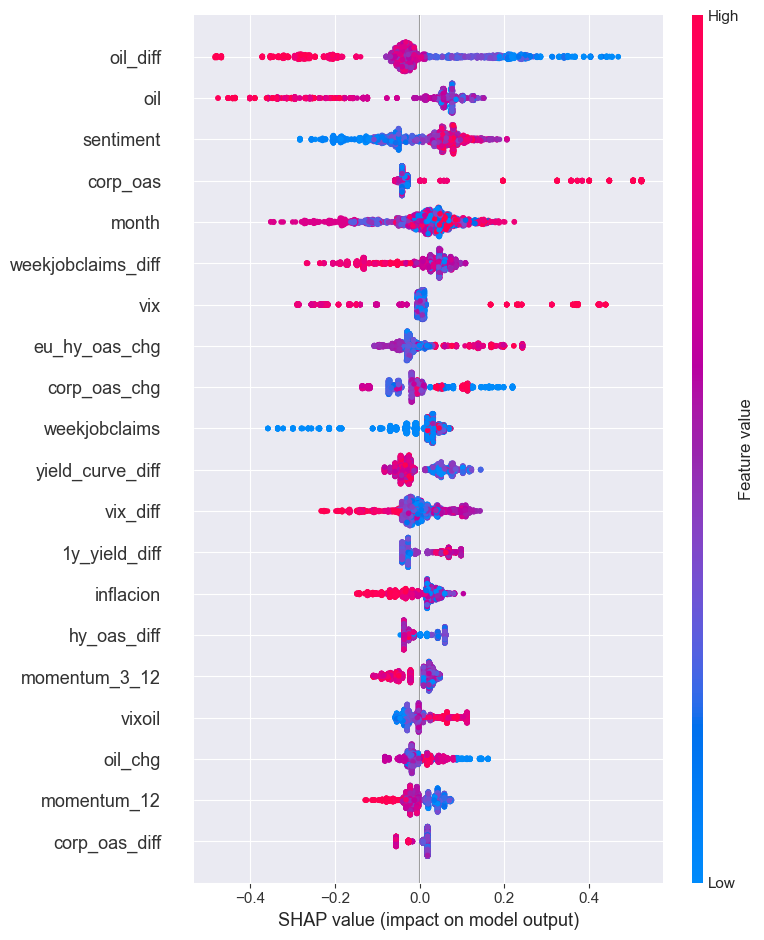

In [48]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X=X)

shap.summary_plot(shap_values, X, show=False)
plt.tight_layout();

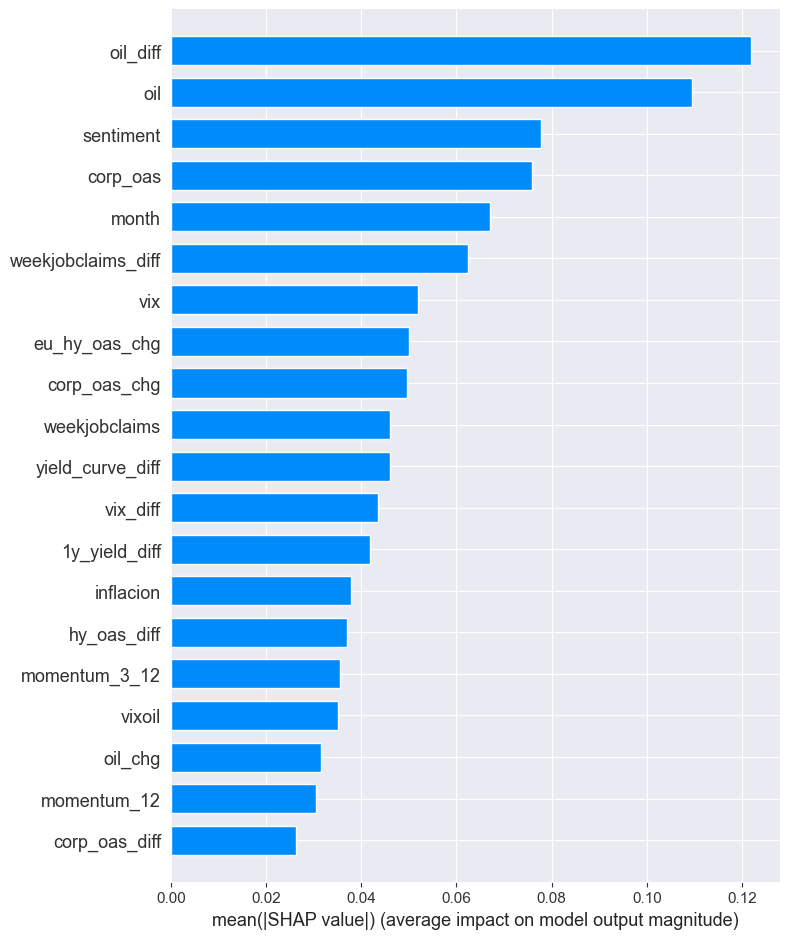

In [49]:
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.tight_layout();

### Feature Interaction

### Force Plots

The following force plot shows the cumulative impact of various features and their values on the model output, which in this case was 0.6, quite a bit higher than the base value of 0.13 (the average model output over the provided dataset). 

Features highlighted in red increase the output. The month being October is the most important feature and increases the output from 0.338 to 0.537, whereas the year being 2017 reduces the output. 

Hence, we obtain a detailed breakdown of how the model arrived at a specific prediction:

In [51]:
i = randint(0, len(X))
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[i, :], X.iloc[i, :])

We can also compute force plots for numerous data points or predictions at a time and use a clustered visualization to gain insights into how prevalent certain influence patterns are across the dataset. 

The following plot shows the force plots for the first 1,000 observations rotated by 90 degrees, stacked horizontally, and ordered by the impact of different features on the outcome for the given observation. 

The implementation uses hierarchical agglomerative clustering of data points on the feature SHAP values to identify these patterns, and displays the result interactively for exploratory analysis, as shown in the following code:

In [52]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :], X.iloc[:1000])

### Interaction Plot

Lastly, SHAP values allow us to gain additional insights into the interaction effects between different features by separating these interactions from the main effects. The shap.dependence_plot  can be defined as follows. It displays how different values for 1-month returns (on the x axis) affect the outcome (SHAP value on the y axis), differentiated by 3-month returns:

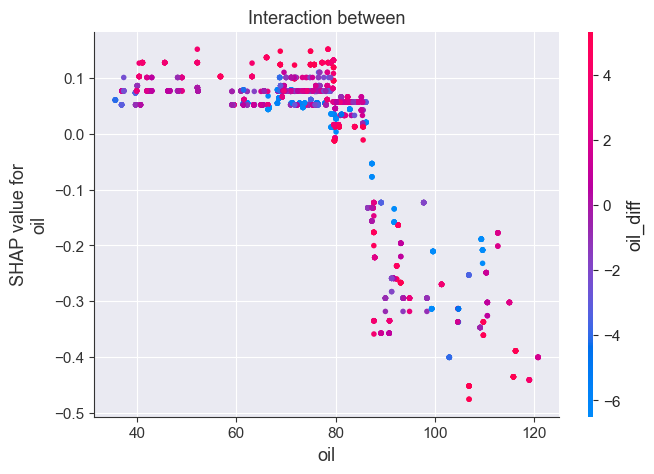

In [50]:
shap.dependence_plot(
    ind="oil",
    shap_values=shap_values,
    features=X,
    interaction_index="oil_diff",
    title="Interaction between",
)

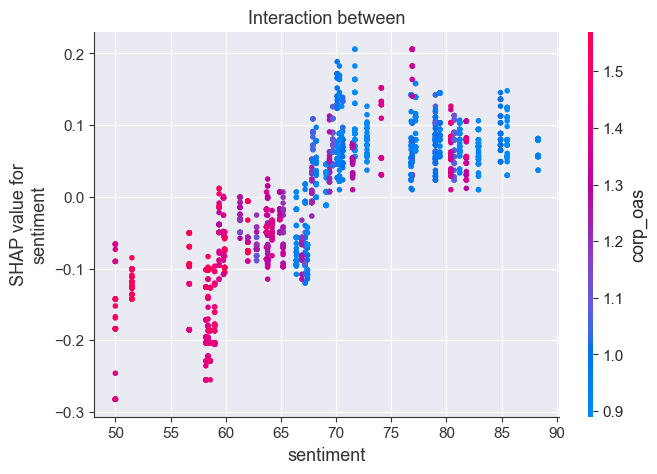

In [51]:
shap.dependence_plot(
    ind="sentiment",
    shap_values=shap_values,
    features=X,
    interaction_index="corp_oas",
    title="Interaction between",
)

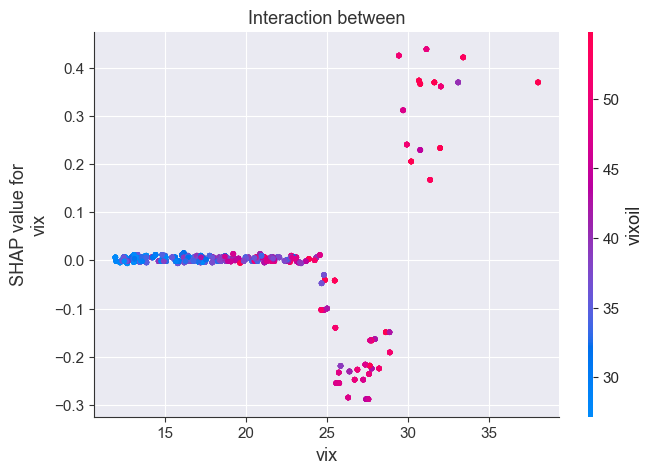

In [52]:
shap.dependence_plot(
    ind="vix",
    shap_values=shap_values,
    features=X,
    interaction_index="vixoil",
    title="Interaction between",
)

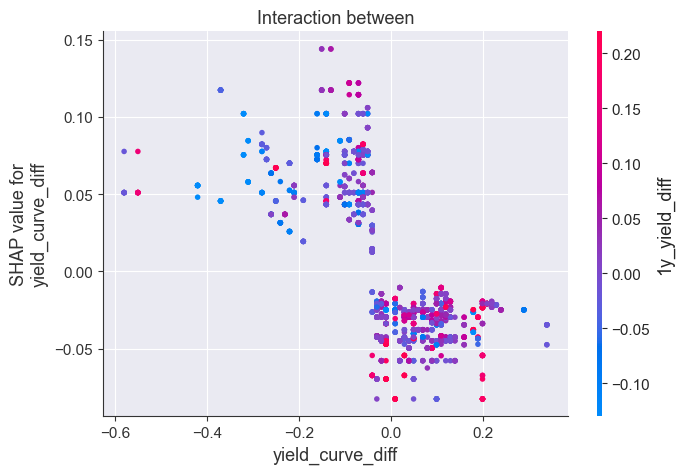

In [53]:
shap.dependence_plot(
    ind="yield_curve_diff",
    shap_values=shap_values,
    features=X,
    interaction_index="1y_yield_diff",
    title="Interaction between",
)

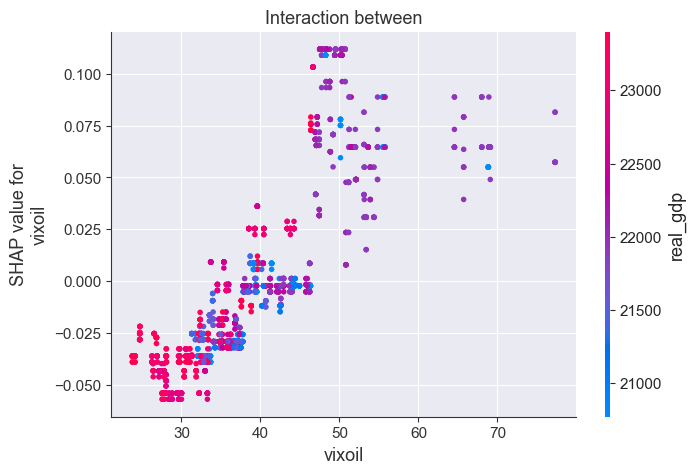

In [57]:
shap.dependence_plot(
    ind="vixoil",
    shap_values=shap_values,
    features=X,
    # interaction_index='return_9m',
    title="Interaction between",
)

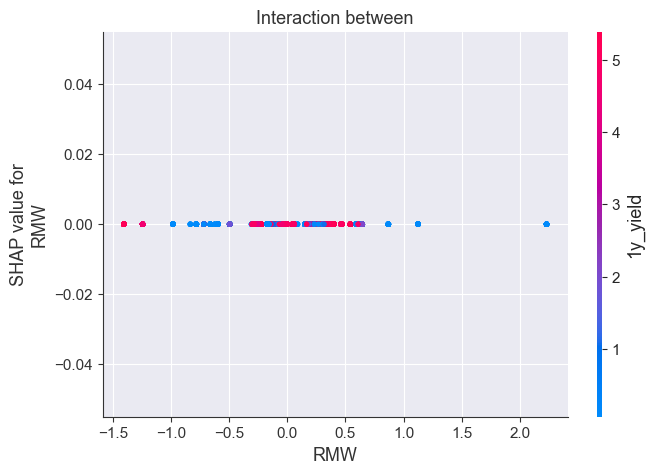

In [58]:
shap.dependence_plot(
    ind="RMW",
    shap_values=shap_values,
    features=X,
    # interaction_index='return_9m',
    title="Interaction between",
)

SHAP values provide granular feature attribution at the level of each individual prediction, and enable much richer inspection of complex models through (interactive) visualization. The SHAP summary scatterplot displayed at the beginning of this section offers much more differentiated insights than a global feature-importance bar chart. Force plots of individual clustered predictions allow for more detailed analysis, while SHAP dependence plots capture interaction effects and, as a result, provide more accurate and detailed results than partial dependence plots.

The limitations of SHAP values, as with any current feature-importance measure, concern the attribution of the influence of variables that are highly correlated because their similar impact could be broken down in arbitrary ways.